In [2]:
import pandas as pd
import numpy as np
import os

_data_dir = './data'
_preprocess_dir = './preprocess'
_predict_dir = './predict'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
def read_csv(path, strip=False):
    res = pd.read_csv(path, skipinitialspace=strip)
    return res


def flat_map(df, key_col, value_col):
    df = df.set_index([key_col])
    new_df = df[value_col].apply(pd.Series).unstack().reset_index().dropna()
    new_df = new_df.iloc[:, 1:]
    new_df = new_df.rename(columns={new_df.columns[0]: 'user_id', new_df.columns[1]: value_col})
    return new_df


def make_original_df(
        driver_action: pd.DataFrame,
        driver_portrait: pd.DataFrame,
        cargo_record: pd.DataFrame,
        city_distance: pd.DataFrame,
        is_train=True):
    """
    合并相关的表（司机画像，司机行为，发货记录）。
    :param city_distance: 城市间距离
    :param driver_action: 司机行为日志
    :param driver_portrait: 司机画像
    :param cargo_record: 发货记录
    :param is_train: 是否训练集
    :return:
    """
    print('Making original DataFrame...')
    res_df = driver_action
    # Join driver portrait.
    res_df = res_df.merge(driver_portrait, on='user_id', how='left')
    res_df = res_df.fillna(method='ffill')

    # Join city_distance.
    city_distance_exc = city_distance.rename(
        columns={'start_city_id': 'end_city_id', 'end_city_id': 'start_city_id'})
    city_distance = pd.concat([city_distance, city_distance_exc], sort=False)
    city_distance = city_distance.drop_duplicates(subset=['start_city_id', 'end_city_id'])

    city_distance['start_province'] = city_distance.start_city_id // 10000
    city_distance['end_province'] = city_distance.end_city_id // 10000

    dist_mean = city_distance.groupby(['start_province', 'end_province']).distance.mean().reset_index()
    dist_mean = dist_mean.rename(columns={'distance': 'mean_distance'})

    cargo_record = cargo_record.drop_duplicates(subset=['id'])
    cargo_record = cargo_record.merge(city_distance, how='left', on=['start_city_id', 'end_city_id'])
    cargo_record['start_province'] = cargo_record.start_city_id // 10000
    cargo_record['end_province'] = cargo_record.end_city_id // 10000
    cargo_record = cargo_record.merge(dist_mean, on=['start_province', 'end_province'], how='left')
    cargo_record.distance.fillna(cargo_record.mean_distance, inplace=True)
    # Join cargo record.
    res_df = res_df.merge(cargo_record, on='id', how='left', suffixes=['_driver', '_cargo'])

    if is_train:
        # 丢弃没有货物信息的样本
        res_df = res_df.dropna(subset=['shipper_id'])

    select_cols = ['user_id', 'gender', 'id', 'install_city_short', 'install_prov_short', 'truck_type_driver',
                   'truck_len', 'regular_subscribe_line', 'line', 'line_30days', 'line_60days',
                   'regular_search_line_3', 'regular_search_line_7', 'regular_search_line_14',
                   'regular_search_line_30',
                   'scan_cargo_cnt_3', 'scan_cargo_cnt_7', 'scan_cargo_cnt_14', 'scan_cargo_cnt_30',
                   'click_cargo_cnt_3', 'click_cargo_cnt_7', 'click_cargo_cnt_14', 'click_cargo_cnt_30',
                   'call_cnt_3', 'call_cnt_7', 'call_cnt_14', 'call_cnt_30', 'call_cnt_45',
                   'call_cargo_cnt_3', 'call_cargo_cnt_7', 'call_cargo_cnt_14', 'call_cargo_cnt_30',
                   'call_cargo_cnt_45', 'open_days_3', 'open_days_7', 'open_days_14', 'open_cnt_3',
                   'open_cnt_7', 'open_cnt_14', 'call_cnt_3', 'call_cnt_7', 'call_cnt_14', 'call_days_3',
                   'call_days_7', 'call_days_14', 'order_days_3', 'order_days_7', 'order_days_14',
                   'order_cnt_3', 'order_cnt_7', 'order_cnt_14', 'distance',
                   'shipper_id', 'start_city_id', 'end_city_id', 'truck_length', 'cargo_capacipy', 'cargo_type',
                   'handling_type', 'highway', 'expect_freight', 'truck_type_list', 'truck_type_cargo',
                   'truck_count', 'mileage', 'lcl_cargo']
    if is_train:
        select_cols.append('label')

    res_df = res_df[select_cols]
    res_df = res_df.rename(columns={'truck_len': 'truck_len_driver', 'truck_length': 'truck_len_cargo',
                                    'cargo_capacipy': 'cargo_capacity'})
    return res_df


def _is_length_match(truck_len: pd.Series,
                     match_target: pd.Series):
    """
    司机画像中的车长是否符合要求。
    :param truck_len: 司机画像中的车长信息
    :param match_target: 发货记录中的车长需求
    :return: pd.Series
    车长是否符合要求
    """
    match_target = pd.Series(match_target.astype(str))
    match_target = match_target.fillna('')
    match_target = match_target.str.split(',')
    match_target = match_target.apply(lambda x: [float(e) for e in x])
    tmp = pd.DataFrame({'truck_len': truck_len, 'target': match_target})
    return tmp.apply(lambda x: x['truck_len'] >= min(x['target']), axis=1)


def _is_line_match(start_end_province: pd.Series,
                   match_target: pd.Series):
    """
    司机画像中的常跑线路和订阅线路是否包含目标起止省份。
    :param start_end_province: 目标省份
    :param match_target: 司机画像中的线路信息
    :return: pd.Series
    是否司机感兴趣的线路
    """
    print('Adding `%s`...' % match_target.name)
    match_target = match_target.fillna('').str.replace('0', '')
    match_target = match_target.str.split(',')
    tmp = pd.DataFrame({'start_end': start_end_province, 'target': match_target})
    return tmp.apply(lambda x: x['start_end'] in x['target'], axis=1)


def make_features_df(ori: pd.DataFrame, is_train=True, bins_path=''):
    """
    构造特征
    :param is_train: 是否是训练集
    :param ori: 连接好的包含用户画像和货物信息的表
    :param bins_path: 训练集持久化保存的且分点路径
    :return: pd.DataFrame
    构造好的特征
    """
    print('Making features DataFrame...')

    res_df = ori.loc[:, ['user_id', 'id', 'label']]

    # gender
    print('Adding `gender`...')
    res_df['gender'] = ori.gender.map({'女': 0, '男': 1, '未知': -1})

    # install_city_short match
    print('Adding `install_city_match`...')
    res_df['install_city_match'] = ori.apply(
        lambda row:
        row['install_city_short'] == row['start_city_id'] or
        row['install_city_short'] == row['end_city_id'], axis=1)

    # cargo_type, handling_type, truck_count, highway, lcl_cargo
    res_df['cargo_type'] = ori.cargo_type.iloc[:].fillna(-1)
    res_df['handling_type'] = ori.handling_type.iloc[:].fillna(0)

    need_count = ori.truck_len_cargo.astype(str).fillna('').str.split(',').apply(len)
    ori.loc[ori.truck_count <= 0, 'truck_count'] = need_count.loc[ori.truck_count <= 0]
    ori.loc[ori.truck_count <= 0, 'truck_count'] = 1
    res_df['truck_count'] = ori.truck_count.fillna(1)

    res_df['highway'] = ori.highway.loc[:].fillna(0)
    res_df['lcl_cargo'] = ori.lcl_cargo.loc[:].fillna(0)

    # Add truck_type related features.
    print('Adding `truck_type_cargo_match*` features...')
    truck_type_driver_order = {}  # key: truck_type_driver, value: truck_type_cargo
    for truck_type in set(ori.truck_type_driver):
        truck_type_driver_order[truck_type] = \
            ori.loc[ori.truck_type_driver == truck_type, ['truck_type_driver', 'truck_type_cargo']][
                'truck_type_cargo'].value_counts().index[:4]

    for i, order in enumerate(['first', 'second', 'third', 'fourth']):
        target_field = 'truck_type_cargo_match_%s' % order
        res_df[target_field] = ori.apply(
            lambda row:
            row['truck_type_driver'] in truck_type_driver_order and
            i < len(truck_type_driver_order[row['truck_type_driver']]) and
            row['truck_type_cargo'] == truck_type_driver_order[row['truck_type_driver']][i], axis=1)

    print('Adding `truck_type_driver_match*` features...')
    truck_type_cargo_order = {}  # key: truck_type_cargo, value: truck_type_driver
    for truck_type in set(ori.truck_type_cargo):
        truck_type_cargo_order[truck_type] = \
            ori.loc[ori.truck_type_cargo == truck_type, ['truck_type_driver', 'truck_type_cargo']][
                'truck_type_driver'].value_counts().index[:4]

    for i, order in enumerate(['first', 'second', 'third', 'fourth']):
        target_field = 'truck_type_driver_match_%s' % order
        res_df[target_field] = ori.apply(
            lambda row:
            row['truck_type_cargo'] in truck_type_cargo_order and
            i < len(truck_type_cargo_order[row['truck_type_cargo']]) and
            row['truck_type_driver'] == truck_type_cargo_order[row['truck_type_cargo']][i], axis=1)

        # Add truck_len_match feature
        print('Adding `truck_len_match`...')
        res_df['truck_len_match'] = _is_length_match(ori.truck_len_driver, ori.truck_len_cargo)

        # Add line match related features.
        ori['start_city_id'] = ori.start_city_id.astype(str)
        ori['end_city_id'] = ori.end_city_id.astype(str)
        start_end = ori.start_city_id.str[:2] + '-' + ori.end_city_id.str[:2]

        # Add regular_subscribe_match feature.
        res_df['regular_subscribe_match'] = _is_line_match(start_end, ori.regular_subscribe_line)
        res_df['regular_subscribe_match'].fillna(False)

        # Add regular_search related features.
        for days in [3, 7, 14, 30]:
            target_field = 'regular_search_%d_match' % days
            ori_field = 'regular_search_line_%d' % days
            res_df[target_field] = _is_line_match(start_end, ori[ori_field])

        # line_match features.
        for sufix in ['', '_30days', '_60days']:
            target_field = 'line%s_match' % sufix
            ori_field = 'line%s' % sufix
            res_df[target_field] = _is_line_match(start_end, ori[ori_field])
            res_df[target_field].fillna(False)

        # Cargo related counts.
        bins = 10
        for action in ['scan', 'click', 'call']:
            avgs = {}
            for days in [3, 7, 14, 30]:
                target_field = '%s_cargo_level_%d' % (action, days)
                ori_field = '%s_cargo_cnt_%d' % (action, days)
                print('Adding `%s`...' % target_field)
                data: pd.Series = ori[ori_field].fillna(0)
                avgs[days] = data.values // days
                res_df[target_field] = pd.cut(data, bins=bins, labels=range(bins))
            avg_filed = '%s_cargo_level_avg' % action
            print('Adding `%s`...' % avg_filed)
            res_df[avg_filed] = avgs[7]

        # # other counts.
        # prefixes = ['open_days', 'open_cnt', 'call_days', 'call_cnt',
        #             'order_days', 'order_cnt']
        #
        # if is_train:
        #     cut_bins = {}
        # else:
        #     # Load persisted `cut_bins` obj.
        #     if os.path.exists(bins_path):
        #         cut_bins = pickle.load(open(bins_path, mode='rb'))
        #     else:
        #         raise FileNotFoundError('File `%s` not found.' % bins_path)
        #
        # for i, prefix in enumerate(prefixes):
        #     for days in [3, 7, 14]:
        #         ori_field = '%s_%d' % (prefix, days)
        #         target_field = '%s_level_%d' % (prefix, days)
        #         print('Adding `%s`...' % target_field)
        #         data: pd.Series = ori[ori_field].fillna(0)
        #         if 'days' in prefix:
        #             res_df[target_field] = data
        #         else:
        #             if is_train:
        #                 res_df[target_field], cut_bins[ori_field] = pd.qcut(
        #                     data, q=bins, labels=False, retbins=True, precision=1, duplicates='drop')
        #             else:
        #                 tmp_bins = cut_bins[ori_field]
        #                 tmp_bins[0], tmp_bins[-1] = data.min(), data.max()  # 确保包含所有元素
        #                 res_df[target_field] = pd.cut(
        #                     data, bins=tmp_bins, labels=False, precision=1, include_lowest=True)
        #
        # if is_train:
        #     # Persist cut_bins for predict data.
        #     if not os.path.exists(os.path.dirname(bins_path)):
        #         os.makedirs(bins_path)
        #     pickle.dump(cut_bins, open(bins_path, mode='wb'))

        return res_df


if __name__ == '__main__':
    _city_distance = pd.read_csv(os.path.join(_data_dir, '城市公路距离记录.csv'))

    # For training.
    _driver_action = pd.read_csv(os.path.join(_data_dir, '司机行为日志.csv'))
    _driver_portrait = pd.read_csv(os.path.join(_data_dir, '司机画像.csv'))
    _cargo_record = pd.read_csv(os.path.join(_data_dir, '货主发货记录.csv'))

    # # make training original DataFrame
    _ori_df = make_original_df(_driver_action, _driver_portrait, _cargo_record, _city_distance)
    _ori_df.to_csv(os.path.join(_preprocess_dir, 'train_original.csv'), index=False)

    # make training features DataFrame
    _ori_df = pd.read_csv(os.path.join(_preprocess_dir, 'train_original.csv'))
    _features_df = make_features_df(_ori_df, is_train=True,
                                    bins_path=os.path.join(_preprocess_dir, 'cut_bins.obj'))
    _features_df.to_csv(os.path.join(_preprocess_dir, 'train_features.csv'), index=False)

    # For prediction.
    _predict = pd.read_csv(os.path.join(_predict_dir, 'predict.csv'), header=None)
    _predict = pd.DataFrame({'user_id': _predict.iloc[:, 0],
                             'id': _predict.iloc[:, 1]})
    _driver_portrait = pd.read_csv(os.path.join(_predict_dir, '司机画像.csv'))
    _cargo_record = pd.read_csv(os.path.join(_predict_dir, '货主发货记录.csv'))

    # make predict original DataFrame
    _ori_df = make_original_df(_predict, _driver_portrait, _cargo_record, _city_distance, is_train=False)
    _ori_df.to_csv(os.path.join(_preprocess_dir, 'predict_original.csv'), index=False)

    # make predict features DataFrame
    _ori_df = pd.read_csv(os.path.join(_preprocess_dir, 'predict_original.csv'))
    _features_df = make_features_df(_ori_df, is_train=False,
                                    bins_path=os.path.join(_preprocess_dir, 'cut_bins.obj'))
    _features_df.to_csv(os.path.join(_preprocess_dir, 'predict_features.csv'), index=False)
    
    

Making original DataFrame...
Making features DataFrame...
Adding `gender`...
Adding `install_city_match`...
Adding `truck_type_cargo_match*` features...
Adding `truck_type_driver_match*` features...
Adding `truck_len_match`...
Adding `regular_subscribe_line`...
Adding `regular_search_line_3`...
Adding `regular_search_line_7`...
Adding `regular_search_line_14`...
Adding `regular_search_line_30`...
Adding `line`...
Adding `line_30days`...
Adding `line_60days`...
Adding `scan_cargo_level_3`...
Adding `scan_cargo_level_7`...
Adding `scan_cargo_level_14`...
Adding `scan_cargo_level_30`...
Adding `scan_cargo_level_avg`...
Adding `click_cargo_level_3`...
Adding `click_cargo_level_7`...
Adding `click_cargo_level_14`...
Adding `click_cargo_level_30`...
Adding `click_cargo_level_avg`...
Adding `call_cargo_level_3`...
Adding `call_cargo_level_7`...
Adding `call_cargo_level_14`...
Adding `call_cargo_level_30`...
Adding `call_cargo_level_avg`...
Making original DataFrame...
Making features DataFram

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Adding `truck_type_cargo_match*` features...
Adding `truck_type_driver_match*` features...
Adding `truck_len_match`...
Adding `regular_subscribe_line`...
Adding `regular_search_line_3`...
Adding `regular_search_line_7`...
Adding `regular_search_line_14`...
Adding `regular_search_line_30`...
Adding `line`...
Adding `line_30days`...
Adding `line_60days`...
Adding `scan_cargo_level_3`...
Adding `scan_cargo_level_7`...
Adding `scan_cargo_level_14`...
Adding `scan_cargo_level_30`...
Adding `scan_cargo_level_avg`...
Adding `click_cargo_level_3`...
Adding `click_cargo_level_7`...
Adding `click_cargo_level_14`...
Adding `click_cargo_level_30`...
Adding `click_cargo_level_avg`...
Adding `call_cargo_level_3`...
Adding `call_cargo_level_7`...
Adding `call_cargo_level_14`...
Adding `call_cargo_level_30`...
Adding `call_cargo_level_avg`...


In [55]:
train_df = pd.read_csv(os.path.join(_preprocess_dir, 'train_features.csv'))

train_df.label = train_df.label.map({2: 1, 1: 1, 0: 0})

X = train_df.drop(['label', 'user_id', 'id'], axis=1)
y = train_df.label

print('X.shape: ', X.shape)
print('y.shape: ', y.shape)

zero_count = y.tolist().count(0)
one_count = y.tolist().count(1)
print('All:  0: %f; 1: %f' % (zero_count * 1.0 / len(y), one_count * 1.0 / len(y)))

X.shape:  (1269117, 36)
y.shape:  (1269117,)
All:  0: 0.937196; 1: 0.062804


In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

zero_count = y_test.tolist().count(0)
one_count = y_test.tolist().count(1)
print('Test:  0: %f; 1: %f' % (zero_count * 1.0 / len(y_test), one_count * 1.0 / len(y_test)))

Test:  0: 0.937468; 1: 0.062532


In [57]:
import lightgbm as lgb

label_weight = {
    0: 1,
    1: 11,
}

gbm = lgb.LGBMClassifier(
    boosting_type='gbdt', 
    max_depth=-1, 
    learning_rate=0.01, 
    subsample_for_bin=200000, 
    objective='binary', 
    class_weight=label_weight, 
    min_split_gain=0.0, 
    min_child_weight=0.001, 
    min_child_samples=20, 
    subsample=1.0, 
    subsample_freq=0, 
    colsample_bytree=1.0, 
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    random_state=None, 
    n_jobs=-1, 
    silent=True,
)

gbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 11},
        colsample_bytree=1.0, learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [59]:
import math

def calc_score(y_test, y_pred):
    assert(len(y_test) == len(y_pred))
    error = 0
    score_weight = {
        0: 1,
        1: 2,
        2: 2.5
    }
    for y_t, y_p in zip(y_test, y_pred):
        error += (y_t * score_weight[y_t] - y_p * score_weight[y_t]) ** 2
    RMSE = math.sqrt(error / len(y_test))
    print('RMSE: ', RMSE)
    print('Score: ', 1 / (1 + RMSE))

y_pred = gbm.predict(X_test)
calc_score(y_test, y_pred)

RMSE:  0.515854289512134
Score:  0.6596940134146022


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [37]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer


def scorer(y_test, y_pred):
    assert(len(y_test) == len(y_pred))
    error = 0
    score_weight = {
        0: 1,
        1: 2,
        2: 2.5
    }
    for y_t, y_p in zip(y_test, y_pred):
        error += (y_t * score_weight[y_t] - y_p) ** 2
    RMSE = math.sqrt(error / len(y_test))
    return 1 / (1 + RMSE)

my_scorer = make_scorer(scorer, greater_is_better=True)

parameters = [
    {'num_leaves': [65,75,80]},
    {'max_depth': [-1]},
    {'learning_rate': [0.01]},
    {'n_estimators': [125, 150, 175]},
    {'subsample_for_bin': [175000, 200000, 225000]},
    {'objective': ['binary']},
    {'class_weight' : [{0: 1, 1: 10}, {0: 1, 1: 10.5}, {0: 1, 1: 11}]}
]

clf = GridSearchCV(gbm, parameters, scoring=my_scorer, cv=5)
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 11},
        colsample_bytree=1.0, learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'num_leaves': [65, 75, 80]}, {'max_depth': [-1]}, {'learning_rate': [0.01]}, {'n_estimators': [125, 150, 175]}, {'subsample_for_bin': [175000, 200000, 225000]}, {'objective': ['binary']}, {'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 10.5}, {0: 1, 1: 11}]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(scorer),
       verbose=0)

In [38]:
print(clf.best_estimator_)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 11},
        colsample_bytree=1.0, learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=80, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [40]:
best_model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 11},
        colsample_bytree=1.0, learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=80, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
calc_score(y_test, y_pred)

RMSE:  0.4858369781515038
Score:  0.6730213439997148


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [22]:
predict_df = pd.read_csv(os.path.join(_preprocess_dir, 'predict_features.csv'))
predict_df.head()

,user_id,id,label,gender,install_city_match,cargo_type,handling_type,truck_count,highway,lcl_cargo,truck_type_cargo_match_first,truck_type_cargo_match_second,truck_type_cargo_match_third,truck_type_cargo_match_fourth,truck_type_driver_match_first,truck_len_match,regular_subscribe_match,regular_search_3_match,regular_search_7_match,regular_search_14_match,regular_search_30_match,line_match,line_30days_match,line_60days_match,scan_cargo_level_3,scan_cargo_level_7,scan_cargo_level_14,scan_cargo_level_30,scan_cargo_level_avg,click_cargo_level_3,click_cargo_level_7,click_cargo_level_14,click_cargo_level_30,click_cargo_level_avg,call_cargo_level_3,call_cargo_level_7,call_cargo_level_14,call_cargo_level_30,call_cargo_level_avg
0,96380588048193900,398829615,NaN,1,False,-1.0,0.0,1.0,0.0,0.0,False,True,False,False,True,False,True,False,False,False,False,True,True,True,2,3,3,3,434.0,1,2,2,3,12.0,0,1,1,2,2.0
1,96436390618420100,399055125,NaN,1,False,-1.0,0.0,1.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,1,2,3,156.0,0,1,2,3,6.0,0,0,2,3,0.0
2,96436391955588500,399018641,NaN,1,True,3.0,1.0,3.0,0.0,0.0,False,True,False,False,True,True,True,False,False,False,False,True,True,True,1,1,1,1,153.0,1,2,3,4,13.0,0,1,1,1,1.0
3,96052842979150500,399245056,NaN,1,False,-1.0,0.0,1.0,0.0,0.0,True,False,False,False,False,True,True,False,False,False,False,True,True,True,3,4,3,3,530.0,1,2,1,2,8.0,1,1,1,1,2.0
4,96436391432418500,399215994,NaN,1,False,0.0,0.0,1.0,0.0,0.0,True,False,False,False,True,True,True,False,False,False,False,True,True,True,0,0,0,1,100.0,1,1,1,2,6.0,1,1,1,3,2.0


In [39]:
y_pred = gbm.predict(predict_df.drop(['user_id', 'id', 'label'], axis=1)) 

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [41]:
predict_df = pd.read_csv(os.path.join(_preprocess_dir, 'predict_features.csv'))
print(predict_df.head())
y_pred = gbm.predict(predict_df.drop(['user_id', 'id', 'label'], axis=1)) 
predict_df.label = pd.Series(y_pred).values
predict_df.loc[:, ["user_id", "id", "label"]].to_csv(os.path.join(_predict_dir, 'predict_result.csv'), index=False)

In [ ]:
"""
数据

基线（提交版本）：
RMSE:  0.5325688703010312
Score:  0.6524992249148173

GBDT最佳模型：
RMSE:  0.512329082971774
Score:  0.6612317459603227
best_model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 10.5},
        colsample_bytree=1.0, learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=150, n_jobs=-1, num_leaves=75, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
        
GBDT模型2:
RMSE:  0.4858369781515038
Score:  0.6730213439997148

best_model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 11},
        colsample_bytree=1.0, learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=80, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
"""

In [92]:
clf = lgb.LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 10},
        colsample_bytree=1.0, learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=80, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
y_pred2 = clf.predict(X_test)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [93]:
list(y_pred2).count(0) * 1.0 / len(y_pred)

0.9188414019162885

0 rows processed.
10000 rows processed.
20000 rows processed.
30000 rows processed.
40000 rows processed.
50000 rows processed.
60000 rows processed.
70000 rows processed.
80000 rows processed.
90000 rows processed.
100000 rows processed.
110000 rows processed.
120000 rows processed.
130000 rows processed.
140000 rows processed.
150000 rows processed.
160000 rows processed.
170000 rows processed.
180000 rows processed.
190000 rows processed.
200000 rows processed.
210000 rows processed.
220000 rows processed.
230000 rows processed.
240000 rows processed.
250000 rows processed.
260000 rows processed.
270000 rows processed.
280000 rows processed.
290000 rows processed.
300000 rows processed.
310000 rows processed.
320000 rows processed.
330000 rows processed.
340000 rows processed.
350000 rows processed.
360000 rows processed.
370000 rows processed.
380000 rows processed.
390000 rows processed.
400000 rows processed.
410000 rows processed.
420000 rows processed.
430000 rows processed.
44

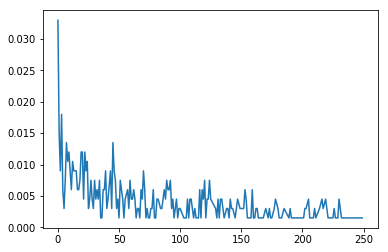

In [153]:
def plot_dist(df):
    df.label = df.label.map({2: 1, 1: 1, 0: 0})

    driver2cargo = {}
    for idx, row in df.iterrows():
        if idx % 10000 == 0:
            print(str(idx) + ' rows processed.')
        if row['user_id'] in driver2cargo:
            if row['label'] != 0:
                driver2cargo[row['user_id']].append(row['id'])
        else:
            if row['label'] != 0:
                driver2cargo[row['user_id']] = [row['id']]
            else:
                driver2cargo[row['user_id']] = []

    empty_rank_cnt = 0
    nonempty_rank_cnt = 0
    x = []
    d = {}
    for k, v in driver2cargo.items():
        x.append(len(v))
        d[len(v)] = d.get(len(v), 0) + 1
        if len(v) == 0:
            empty_rank_cnt += 1
        else:
            nonempty_rank_cnt += 1

    print(empty_rank_cnt, nonempty_rank_cnt)
    print(sorted(d.items(), key=lambda kv: kv[0], reverse=True))
    
    import matplotlib.pyplot as plt
    
    x = []
    y = []
    for k, v in sorted(d.items(), key=lambda kv: kv[0], reverse=True):
        if k > 250:
            continue
        x.append(k)
        y.append(v * 1.0 / (empty_rank_cnt + nonempty_rank_cnt))
    
#     plt.figure()
    plt.plot(x,y)
    
    plt.show()

plot_dist(train_df)

In [156]:
def plot_dist(df, threshold):
    driver2cargo = {}
    for idx, row in df.iterrows():
        if idx % 10000 == 0:
            print(str(idx) + ' rows processed.')
        if row['user_id'] in driver2cargo:
            if row['predicted_prob'] > threshold:
                driver2cargo[row['user_id']].append(row['id'])
        else:
            if row['predicted_prob'] > threshold:
                driver2cargo[row['user_id']] = [row['id']]
            else:
                driver2cargo[row['user_id']] = []

    empty_rank_cnt = 0
    nonempty_rank_cnt = 0
    x = []
    d = {}
    for k, v in driver2cargo.items():
        x.append(len(v))
        d[len(v)] = d.get(len(v), 0) + 1
        if len(v) == 0:
            empty_rank_cnt += 1
        else:
            nonempty_rank_cnt += 1

            
    print(empty_rank_cnt, nonempty_rank_cnt)
    print(sorted(d.items(), key=lambda kv: kv[0], reverse=True))

    import matplotlib.pyplot as plt
    
    x = []
    y = []
    for k, v in sorted(d.items(), key=lambda kv: kv[0], reverse=True):
        x.append(k)
        y.append(v * 1.0 / (empty_rank_cnt + nonempty_rank_cnt))
    
#     plt.figure()
    plt.plot(x,y)
    
    plt.show()

# plot_dist(train_df)

0 rows processed.
10000 rows processed.
5 485
[(255, 1), (234, 1), (196, 1), (188, 1), (138, 1), (133, 1), (132, 1), (128, 1), (122, 1), (120, 1), (119, 1), (112, 1), (111, 1), (109, 1), (108, 1), (95, 2), (94, 1), (88, 1), (85, 3), (84, 2), (81, 3), (79, 2), (78, 1), (76, 1), (75, 1), (74, 1), (72, 2), (69, 1), (67, 2), (66, 2), (62, 1), (61, 3), (59, 3), (58, 3), (57, 2), (56, 1), (55, 2), (54, 3), (53, 2), (52, 3), (51, 2), (50, 2), (49, 3), (48, 3), (47, 4), (46, 2), (45, 5), (44, 2), (43, 5), (42, 2), (39, 3), (38, 4), (37, 5), (36, 3), (35, 3), (34, 1), (33, 4), (32, 7), (31, 8), (30, 3), (29, 5), (28, 6), (27, 4), (26, 5), (25, 6), (24, 7), (23, 4), (22, 10), (21, 7), (20, 8), (19, 8), (18, 10), (17, 8), (16, 14), (15, 8), (14, 12), (13, 9), (12, 14), (11, 16), (10, 11), (9, 12), (8, 15), (7, 19), (6, 14), (5, 26), (4, 25), (3, 22), (2, 26), (1, 20), (0, 5)]


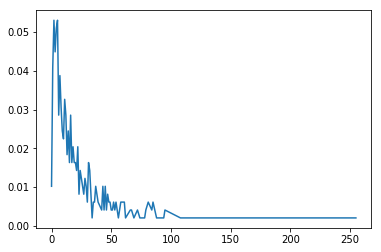

In [187]:
clf = lgb.LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 11},
        colsample_bytree=1.0, learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=80, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

x_train_67 = np.load('x_train_67_dedup.npy')
y_train_67 = np.load('y_train_67_dedup.npy')
clf.fit(x_train_67, y_train_67)

predict_df = pd.read_csv('x_predict.csv')
predict_df = predict_df.rename(columns={predict_df.columns[0]: 'user_id', predict_df.columns[1]: 'id'})

y_pred_prob = clf.predict_proba(predict_df.drop(['user_id', 'id'], axis=1))
predict_df['predicted_prob'] = pd.Series(y_pred_prob[:,1]).values

plot_dist(predict_df, 0.28)

In [121]:
# DNN预测结果

def plot_dist(predict_df, y_pred, threshold):
    predict_df['predicted_prob'] = pd.Series(y_pred[:,1]).values
    driver2cargo = {}
    for idx, row in df.iterrows():
        if idx % 10000 == 0:
            print(str(idx) + ' rows processed.')
        if row['user_id'] in driver2cargo:
            if row['predicted_prob'] > threshold:
                driver2cargo[row['user_id']].append(row['id'])
        else:
            if row['predicted_prob'] > threshold:
                driver2cargo[row['user_id']] = [row['id']]
            else:
                driver2cargo[row['user_id']] = []

    empty_rank_cnt = 0
    nonempty_rank_cnt = 0
    x = []
    d = {}
    for k, v in driver2cargo.items():
        x.append(len(v))
        d[len(v)] = d.get(len(v), 0) + 1
        if len(v) == 0:
            empty_rank_cnt += 1
        else:
            nonempty_rank_cnt += 1

    print(empty_rank_cnt, nonempty_rank_cnt)
    print(sorted(d.items(), key=lambda kv: kv[0], reverse=True))
    
    import matplotlib.pyplot as plt
    
    x = []
    y = []
    for k, v in sorted(d.items(), key=lambda kv: kv[0], reverse=True):
        if k > 250:
            continue
        x.append(k)
        y.append(v * 1.0 / (empty_rank_cnt + nonempty_rank_cnt))
    
#     plt.figure()
    plt.plot(x,y)
    
    plt.show()

plot_dist(predict_df, dnn_y_pred, 0.3)


Index(['user_id', 'id', 'predicted_prob'], dtype='object')

In [190]:
from datetime import datetime
from collections import OrderedDict

time = datetime.now().strftime('%H_%M_%S')

clf = lgb.LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 11},
        colsample_bytree=1.0, learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=80, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

clf.fit(x_train_67, y_train_67)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 11},
        colsample_bytree=1.0, learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=80, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [194]:
def save_predict_file():
    predict_df = pd.read_csv('x_predict.csv')
    predict_df = predict_df.rename(columns={predict_df.columns[0]: 'user_id', predict_df.columns[1]: 'id'})
    y_pred_prob = clf.predict_proba(predict_df.drop(['user_id', 'id'], axis=1))
    predict_df['predicted_prob'] = pd.Series(y_pred_prob[:,1]).values
    
    driver_to_cargo_list = {}
    for idx, row in predict_df.iterrows():
        if idx % 1000 == 0:
            print(str(idx) + ' processed.')
        if row['predicted_prob'] < 0.275:
            if row['user_id'] in driver_to_cargo_list:
                pass
            else:  
                driver_to_cargo_list[row['user_id']] = {}
            continue
        if row['user_id'] in driver_to_cargo_list:
            driver_to_cargo_list[row['user_id']][row['id']] = row['predicted_prob']
        else:
            driver_to_cargo_list[row['user_id']] = {row['id']: row['predicted_prob']}

    with open(os.path.join(_predict_dir, '%s.csv' % datetime.now().strftime('%H_%M_%S')), 'w') as out:
        for k, v in driver_to_cargo_list.items():
            sorted_cargo_id_prob = sorted(v.items(), key=lambda x:x[1])
            sorted_cargo_id = [t1 for t1, t2 in sorted_cargo_id_prob]
            out.write(str(k) + '\t')
            if len(sorted_cargo_id) > 0:
                for i in sorted_cargo_id[0:-1]:
                    out.write(str(i) + ',')
                out.write(str(sorted_cargo_id[-1]) + '\n')
            else:
                out.write('\n')
save_predict_file()

0 processed.
1000 processed.
2000 processed.
3000 processed.
4000 processed.
5000 processed.
6000 processed.
7000 processed.
8000 processed.
9000 processed.
10000 processed.
11000 processed.
12000 processed.
13000 processed.
14000 processed.


In [76]:
plot_dist(predict_df, 0.28)

15000

In [85]:
d = {'user_id': ['3', '4', '3', '4', '3', '7'], 'id': ['14','15','16','17','18', '19'], 'predicted_prob': [0.7, 0.6, 0.8, 0.9, 1.0, 0.1]}
predict_df = pd.DataFrame(data=d)

print(predict_df)

driver_to_cargo_list = {}
for idx, row in predict_df.iterrows():
    if idx % 1000 == 0:
        print(str(idx) + ' processed.')
    if row['predicted_prob'] < 0.5:
        driver_to_cargo_list[row['user_id']] = {}
        continue
    if row['user_id'] in driver_to_cargo_list:
        driver_to_cargo_list[row['user_id']][row['id']] = row['predicted_prob']
    else:
        driver_to_cargo_list[row['user_id']] = {row['id']: row['predicted_prob']}
    
with open(os.path.join(_predict_dir, '%s.csv' % datetime.now().strftime('%H_%M_%S')), 'w') as out:
    for k, v in driver_to_cargo_list.items():
        sorted_cargo_id_prob = sorted(v.items(), key=lambda x:x[1])
        sorted_cargo_id = [t1 for t1, t2 in sorted_cargo_id_prob]
        out.write(str(k) + '\t')
        for i in sorted_cargo_id[0:-1]:
            out.write(str(i) + ',')
        out.write(str(sorted_cargo_id[-1]) + '\n')

  user_id  id  predicted_prob
0       3  14             0.7
1       4  15             0.6
2       3  16             0.8
3       4  17             0.9
4       3  18             1.0
5       7  19             0.1
0 processed.


IndexError: list index out of range

In [175]:
np.save('x_train', X_train)
np.save('x_test', X_test)
np.save('y_train', y_train)
np.save('y_test', y_test)
np.save('x_predict', predict_df.drop(['user_id', 'id', 'label'], axis=1))